Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
28.07.25 - Orchisama Das, Gloria Dal Santo
  
### L07: Ambisonics-encoded RIRs

In this assignment we will 
- Convert A-format FOA recordings to B-format.
- Visualise spherical harmomic basis functions.
- Save B-format SRIRs in a SOFA file for multiple listener positions.
- Listen to auralization with saved SRIRs either binaurally or out-loud in the 22.1 setup in CCRMA's studio E.

In [1]:
import numpy as np
import soundfile as sf
import sofar

from pathlib import Path
import matplotlib.pyplot as plt
from loguru import logger
from utils import rir_from_sweep, find_onset, ms_to_samps
from spatial_audio.spatial import convert_A2B_format_tetramic
from spatial_audio.plot import plot_spherical_harmonics
from spatial_audio.sofa_parser import SRIRWriter

### Part 1
- Complete the multichannel deconvolution function `utils.rir_from_sweep()`
- Given the sine sweeps measured in the racquetball court at receiver locations, A,D,G,H,J,K for source location I, C, B and the dry sweep, deconvolve them to get A-format RIRs. The measured RIRs are in the GDrive folder `Assignments/Data/Week 2/shoe-box-synth-comp/ambi_rec/`. 

2025-07-29 17:25:08.306 | INFO     | __main__:<module>:12 - Calculating RIRs for source position I


2025-07-29 17:25:08.664 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position A
2025-07-29 17:25:09.283 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position D
2025-07-29 17:25:09.959 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position G
2025-07-29 17:25:10.617 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position H
2025-07-29 17:25:11.379 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position K
2025-07-29 17:25:11.725 | INFO     | __main__:<module>:12 - Calculating RIRs for source position C
2025-07-29 17:25:12.162 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position A
2025-07-29 17:25:13.021 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position D
2025-07-29 17:25:13.821 | INFO     | __main__:<module>:19 - Done calculating RIRs for receiver position G
2025-07-29 17:25:14.580 | INFO     | __main__:<module

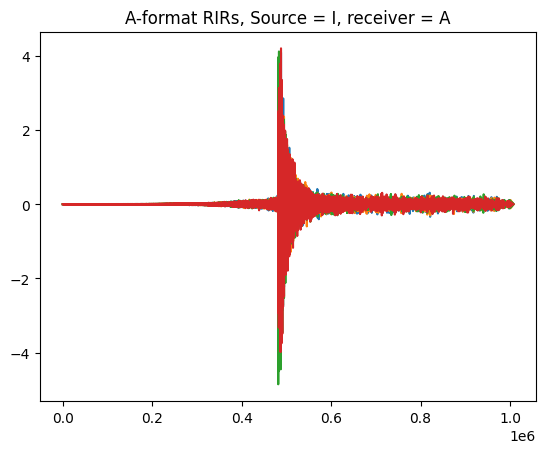

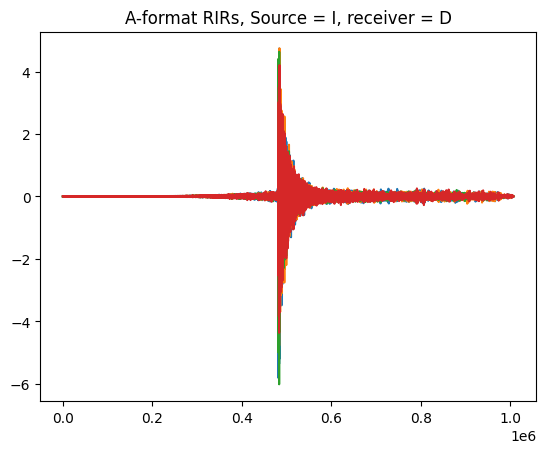

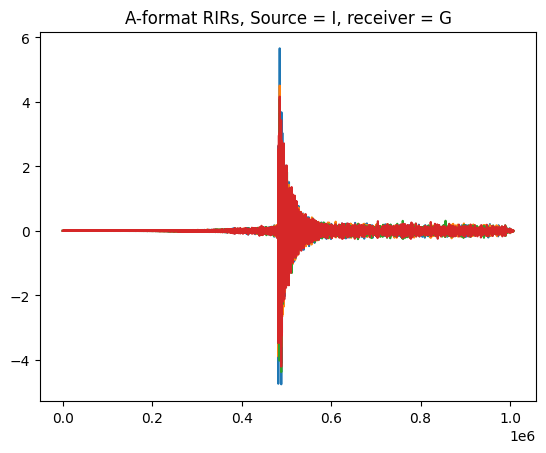

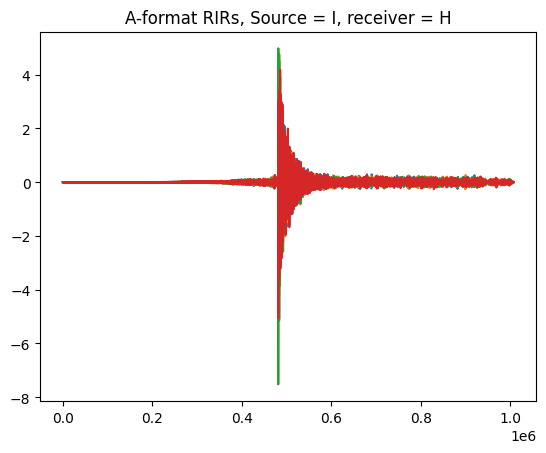

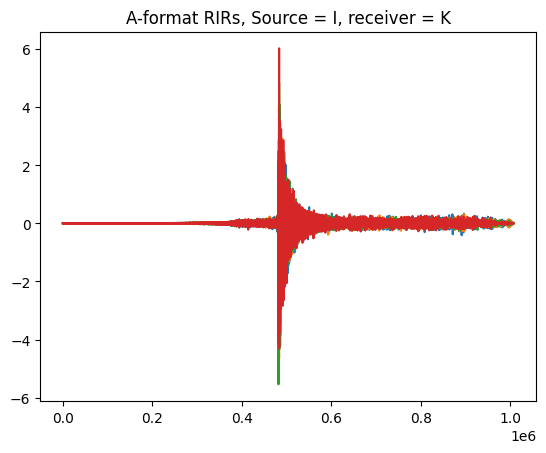

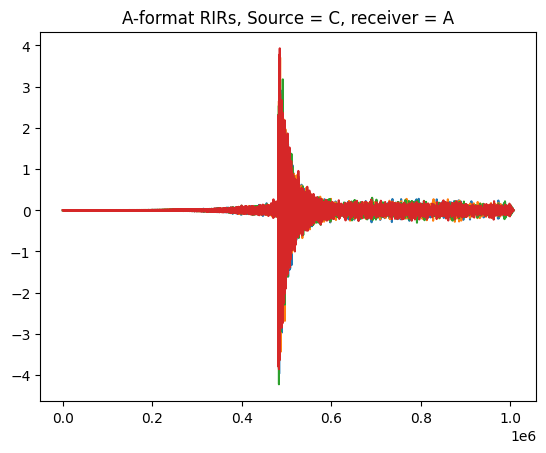

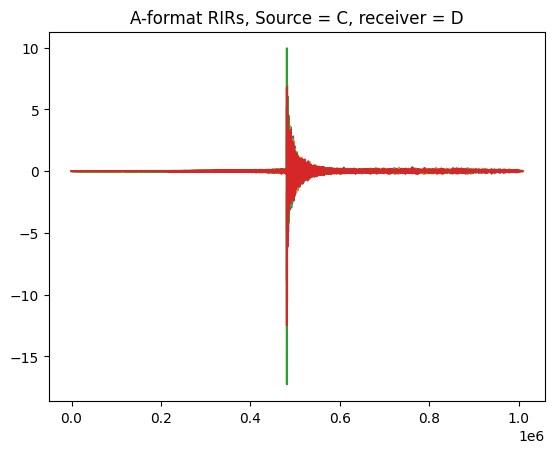

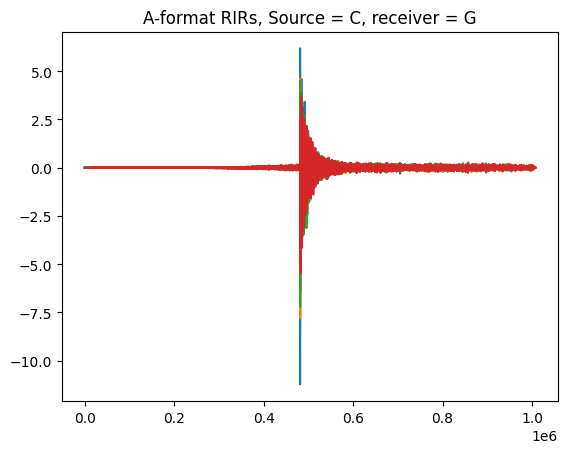

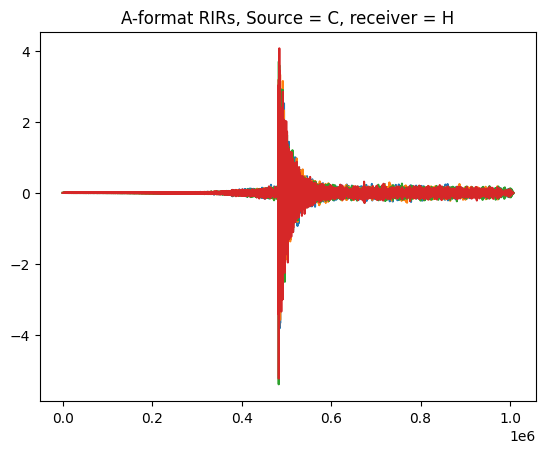

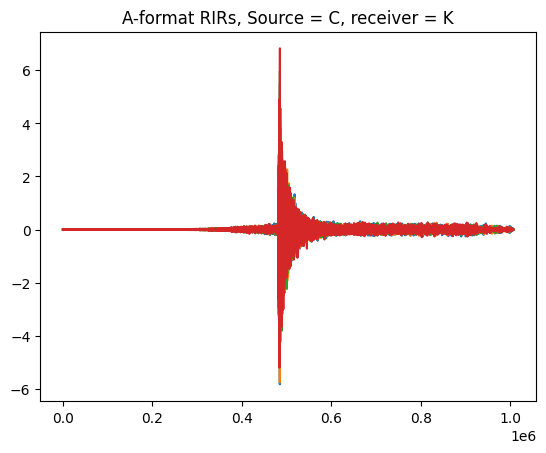

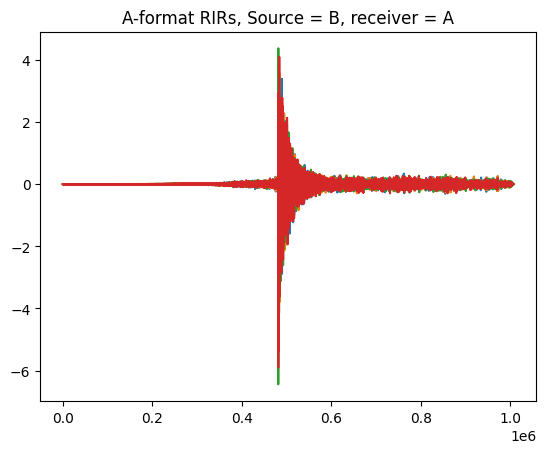

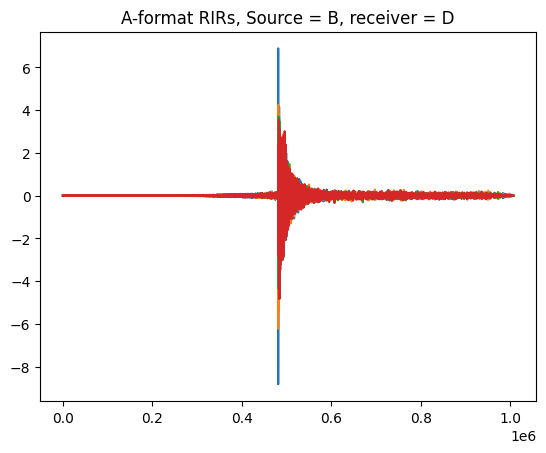

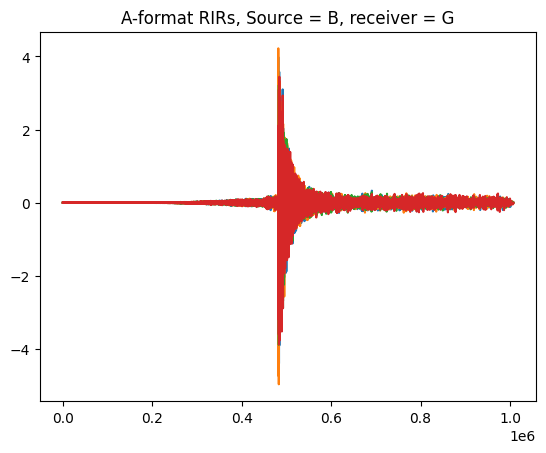

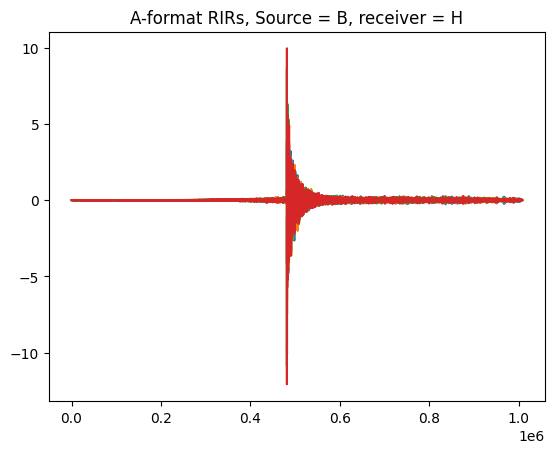

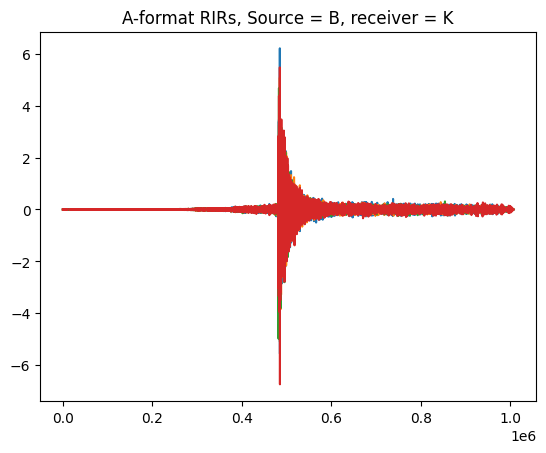

In [2]:
# Read DrySweep
audio_path = Path('../data/Week 2/shoe-box-synth-comp/ambi_rec').resolve()
dry_sweep, fs = sf.read(f'{audio_path}/DrySweep.wav')

# Define source and receiver names
src_name = ['I', 'C', 'B']
rec_name = ['A','D','G','H','K']

# Loop through source and receivers to get all the RIRs
rirs_Aformat = {}
for k in range(len(src_name)):
    logger.info(f"Calculating RIRs for source position {src_name[k]}")
    for i in range(len(rec_name)):
        # Read measured sweeps
        meas_sweep, fs = sf.read(f'{audio_path}/Speaker_src={src_name[k]}_rec={rec_name[i]}.wav')
        
        # Call rir_from_sweep to get A-format RIRs for current receiver and source
        rirs_Aformat[src_name[k]+rec_name[i]] = rir_from_sweep(meas_sweep, dry_sweep, fs)
        logger.info(f"Done calculating RIRs for receiver position {rec_name[i]}")
        
        # Plot the A format RIRs for current source and listener positions
        plt.figure()
        plt.plot(rirs_Aformat[src_name[k]+rec_name[i]])
        plt.title(f'A-format RIRs, Source = {src_name[k]}, receiver = {rec_name[i]}')

### Part 2

- Convert the A-format recordings to B-format using SN3D normalization and ACN channel ordering by completing the function `convert_A2B_format_tetramic()` in `spatial_audio.spatial.py`.
- Recall that we want to convert from A-format RIRs, $\mathbf{d}(t) = \begin{bmatrix}d_1(t) & d_2(t) & d_3(t) & d_4(t) \end{bmatrix}^\top$ to B-format RIRs, $\mathbf{h}(t) = \begin{bmatrix}W(t) & Y(t) & Z(t) & X(t) \end{bmatrix}^\top$, using the spherical harmonics transformation matrix $\mathbf{Y}$. The pseudo-inverse of $\mathbf{Y}$ is given by $\mathbf{Y}^\dagger$.
\begin{equation}
    \begin{aligned}
    \mathbf{h}(t) &= \mathbf{Y}^\dagger \mathbf{d}(t) \\
    \mathbf{Y} &= \begin{bmatrix}Y_{0,0}(\boldsymbol{\theta, \phi}) & Y_{1,-1}(\boldsymbol{\theta, \phi}) & Y_{1,0}(\boldsymbol{\theta, \phi}) & Y_{1,1}(\boldsymbol{\theta, \phi}) \end{bmatrix}, \\
    Y_{0,0}(\boldsymbol{\theta, \phi}) & =\frac{1}{\sqrt{4 \pi}} \\
    Y_{1,-1}(\boldsymbol{\theta, \phi}) & =\sqrt{\frac{3}{4 \pi}} \sin \boldsymbol{\theta} \sin \boldsymbol{\phi} \\
    Y_{1,0}(\boldsymbol{\theta, \phi}) & =\sqrt{\frac{3}{4 \pi}} \cos \boldsymbol{\theta} \\
    Y_{1,1}(\boldsymbol{\theta, \phi}) & =\sqrt{\frac{3}{4 \pi}} \sin \boldsymbol{\theta} \cos \boldsymbol{\phi} \\
    \boldsymbol{\theta}, \boldsymbol{\phi} &\in \mathbb{R}^4, \ \theta_i = \arccos(z_i), \ \phi_i = \arctan(y_i, x_i) \\
    \mathbf{e}_i &= \frac{1}{\sqrt{3}}\begin{bmatrix} x_i & y_i & z_i\end{bmatrix}^\top.
    \end{aligned}
    \end{equation}
    Here, $\mathbf{e}_i$ contains the direction vectors for each of the four capsules of the tetramic (this has been provided in the code). Hint: the calculations can be greatly simplified if you calculate $\theta_i, \phi_i$ from $\mathbf{e}_i$ and plug it in $\mathbf{Y}$.

In [ ]:
rirs_Bformat = {}
rirs_onset = {}
time = np.linspace(0, (rirs_Aformat['CA'].shape[0]-1)/fs, rirs_Aformat['CA'].shape[0])

for k in range(len(src_name)):
    for i in range(len(rec_name)):
        # Get B-format RIRs by calling convert_A2B_format_from_tetramic()
        rirs_Bformat[src_name[k] + rec_name[i]] = convert_A2B_format_tetramic(rirs_Aformat[src_name[k] + rec_name[i]])
        
        # Get onsets for each RIR by calling find_onset
        rirs_onset[src_name[k] + rec_name[i]] = find_onset(rirs_Bformat[src_name[k] + rec_name[i]])
        logger.info(f"Done calculating RIRs for receiver position {rec_name[i]}")

        # Plot B-format RIRs for current source and listener positions
        plt.figure()
        plt.plot(time, rirs_Bformat[src_name[k] + rec_name[i]])
        plt.title(f'B-format RIRs, Source = {src_name[k]}, receiver = {rec_name[i]}')
        plt.legend(['W','Y','Z','X'])

2025-07-29 17:25:33.759 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position A
2025-07-29 17:25:34.926 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position D
2025-07-29 17:25:36.248 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position G
2025-07-29 17:25:38.039 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position H
2025-07-29 17:25:39.718 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position K
2025-07-29 17:25:41.157 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position A
2025-07-29 17:25:42.441 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position D
2025-07-29 17:25:43.706 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position G
2025-07-29 17:25:45.319 | INFO     | __main__:<module>:12 - Done calculating RIRs for receiver position H
2025-07-29 17:25:46.472 | INFO     | __main__:

### Part 3

Using `spatial_audio.plot.plot_spherical_harmonics`, visualise spherical harmonic functions up to order 3.

In [ ]:
#plot_spherical_harmonics([0, 1, 2, 3])

### Part 4
Save the B-format recordings as wav files with the convention `Bformat_Speaker_src={src_pos_name}_rec={rec_pos_name}.wav`. The files can be saved in the folder `../data/Week 2/shoe-box-synth-comp/ambi_rec/`.

In [ ]:
# Trim the RIRs to be 10s long and normalize them to be within +/- 1
start_trim_len_samps = ms_to_samps(10000, fs)
end_trim_len_samps = ms_to_samps(5000, fs)
rirs_Bformat_array = np.stack(list(rirs_Bformat.values()))
rirs_Bformat_array = rirs_Bformat_array[:,start_trim_len_samps:-end_trim_len_samps, :]
norm_factor = np.max(np.abs(rirs_Bformat_array), axis=1, keepdims=True)
rirs_Bformat_norm = rirs_Bformat_array / norm_factor

# Save wave files
j = 0
for k in range(len(src_name)):
    for i in range(len(rec_name)):  
        filename = rf'C:\Users\Tanay Mannikar\Documents\VAIAWorkshop25Public\data\Week 2\shoe-box-synth-comp\ambi_rec\Bformat_Speaker_src={src_name[k]}_rec={rec_name[i]}.wav' 
        with sf.SoundFile(filename, 'w', fs, rirs_Bformat_norm.shape[-1]) as f: 
            f.write(rirs_Bformat_norm[j])
        j += 1

### Part 5
Save the B-format normalized SRIRs for each source in a different SOFA file of convention `SingleRoomSRIR` file using the `SRIRWriter` class.

In [ ]:
# Length of the RIRs we are saving in SOFA format
ir_length = rirs_Bformat['CA'].shape[0] - end_trim_len_samps - start_trim_len_samps

# SH order
ambi_order = 1

# Sampling rate
samplerate = fs

# Create source and receiver position arrays (x is front, y is left)
src_pos = np.asarray([[5.3, 6.7, 1.5], [3.048, 9.14, 1.5], [3.048, 6.1, 1.5]])
rec_pos = np.asarray([[1.524, 3.05, 1.5], [2.032, 8.13, 1.5], [1, 10.5, 1.5], [2.7, 4.5, 1.5], [3.048, 1, 1.5]])

# Number of receivers
num_rec = rec_pos.shape[0]

# Room dimensions (optional)
room_dims = np.array([6.096, 12.19, 6.096])

# ensure B-format RIR array has the right dimensions - (number of measurements, number of channels, length of RIRs)
rirs_Bformat_norm = rirs_Bformat_norm.transpose(0, -1, 1)
rirs_onset_array = np.stack(list(rirs_onset.values()))

In [ ]:
for i in range(len(src_name)):
    # current sofa path
    sofa_path = Path(f'../data/Week 2/shoe-box-synth-comp/sofa_files/racquetball_src={src_name[i]}_srirs.sofa').resolve()
    # create SRIRWriter object
    srir_writer = SRIRWriter(num_receivers=num_rec, num_channels=rirs_onset_array.shape[-1],
                             ir_length=ir_length, samplerate=samplerate, room_dims=room_dims)
    # set source positions
    srir_writer.set_source_positions(src_pos)
    # set listener positions
    srir_writer.set_listener_positions(rec_pos)
    # set impulse response data
    srir_writer.set_ir_data(rirs_onset_array)
    # optional - set onset delays
    # save sofa to file
    srir_writer.write_to_file(sofa_path)

AssertionError: Source positions should be of size M, 3

In [ ]:
# OPTIONAL - Read SOFA file to ensure everything was saved properly

sofa_reader = sofar.read_sofa(sofa_path)
sofa_reader.list_dimensions

ValueError: C:\Users\Tanay Mannikar\Documents\VAIAWorkshop25Public\data\Week 2\shoe-box-synth-comp\sofa_files\racquetball_src=B_srirs.sofa does not exist